In [ ]:
import sys

sys.path.append("../../") # go to parent dir

In [1]:
from sklearn.linear_model import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from modelos import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
pd.options.display.max_columns = 50 # para mostrar todas las columnas

#### Evaluación para altura de las olas
(nos fijaremos en los mjeores modelos segun raiz de ECM

In [3]:
# Para el modelo con todas las variables
X_train, X_test, y_train, y_test = sep_train_test()
# Eliminamos las columnas repetidas y las columnas temporales (visto en el notebook del analisis)
X_train = X_train.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])
X_test = X_test.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])

In [4]:
def class_ola(ola):
    if (ola < 1):
        return "x<1"
    if (ola < 2):
        return "1<x<2"
    if (ola < 3):
        return "2<x<3"
    else:
        return "x>3"

In [5]:
ola_clas = y_test.map(class_ola)

<Axes: title={'center': 'Segmentación de olas'}>

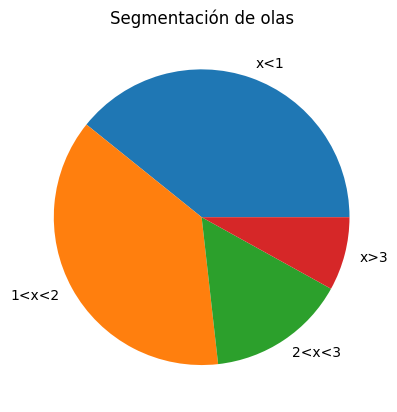

In [6]:
ola_clas.value_counts().plot(kind='pie', label='', title='Segmentación de olas')

In [ ]:
def evaluate_wave_error_distr(model_name, x_te = None):
    flo = MLFlow()

    model = flo.get_saved_model(model_name)
    if x_te is None:
        x_te = X_test
    olas_err = pd.DataFrame({"ola": ola_clas, "error": y_test - model.predict(x_te)})
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    for i, o in enumerate(olas_err.ola.unique()):
        ax[i//2, i%2].hist(olas_err[olas_err["ola"] == o].error, label=o, density=True)
        ax[i//2, i%2].set_title(o)

#### LinearModel

C:\Users\dacoq\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


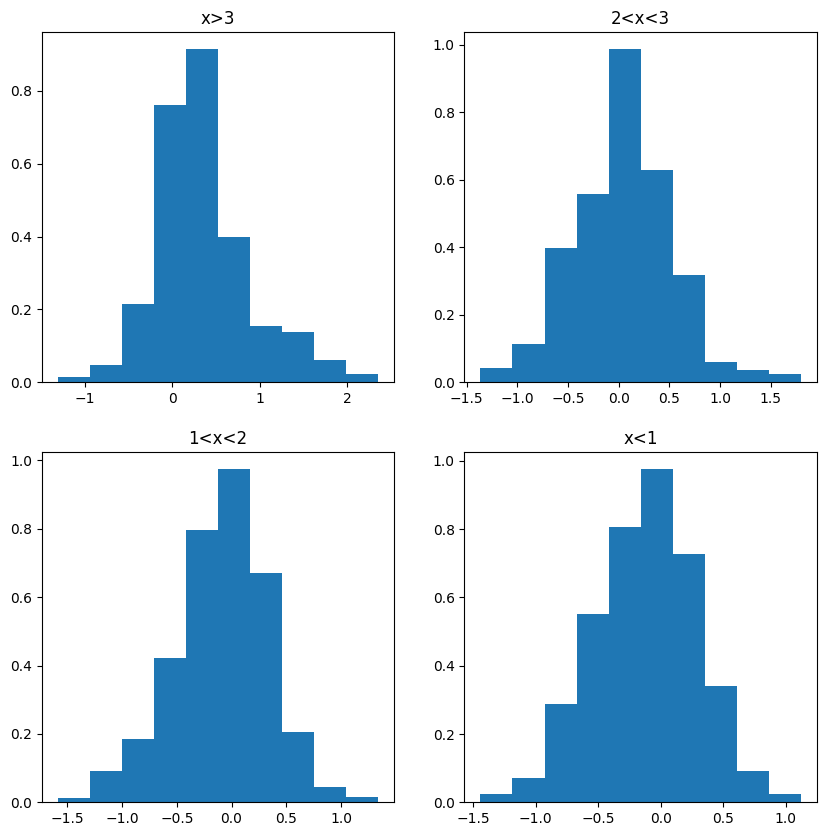

In [9]:
evaluate_wave_error_distr("lineal-sin-regularizar")

#### Ridge

Text(0.5, 0.98, 'RIDGE')

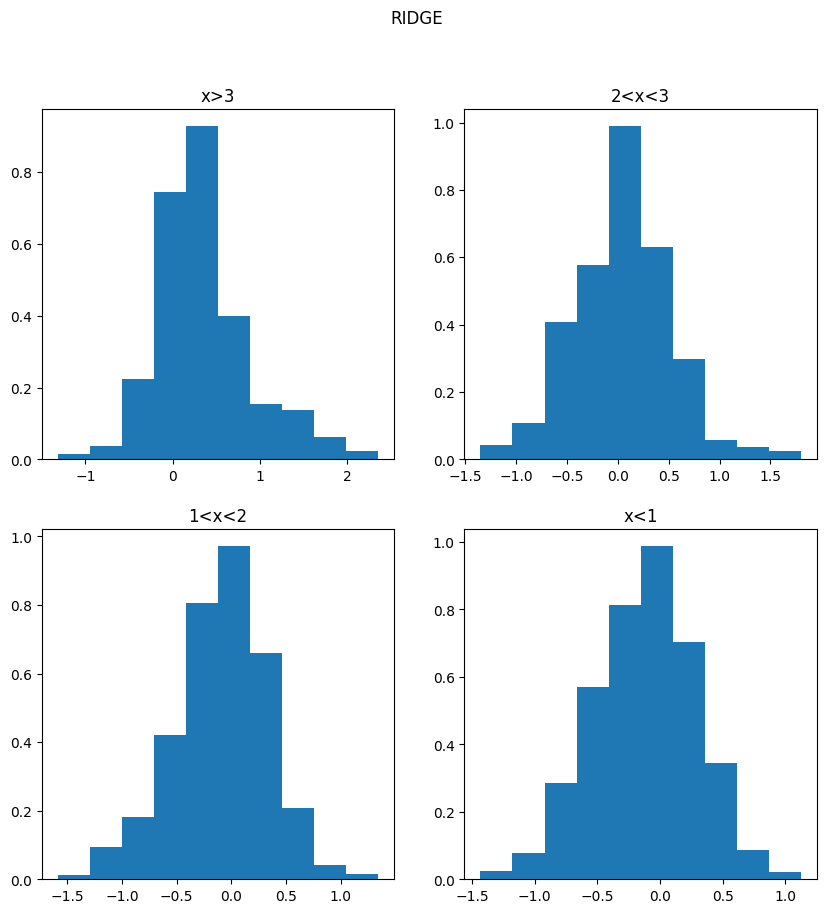

In [11]:
evaluate_wave_error_distr("ridge")
plt.suptitle("RIDGE")

#### Lasso

C:\Users\dacoq\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


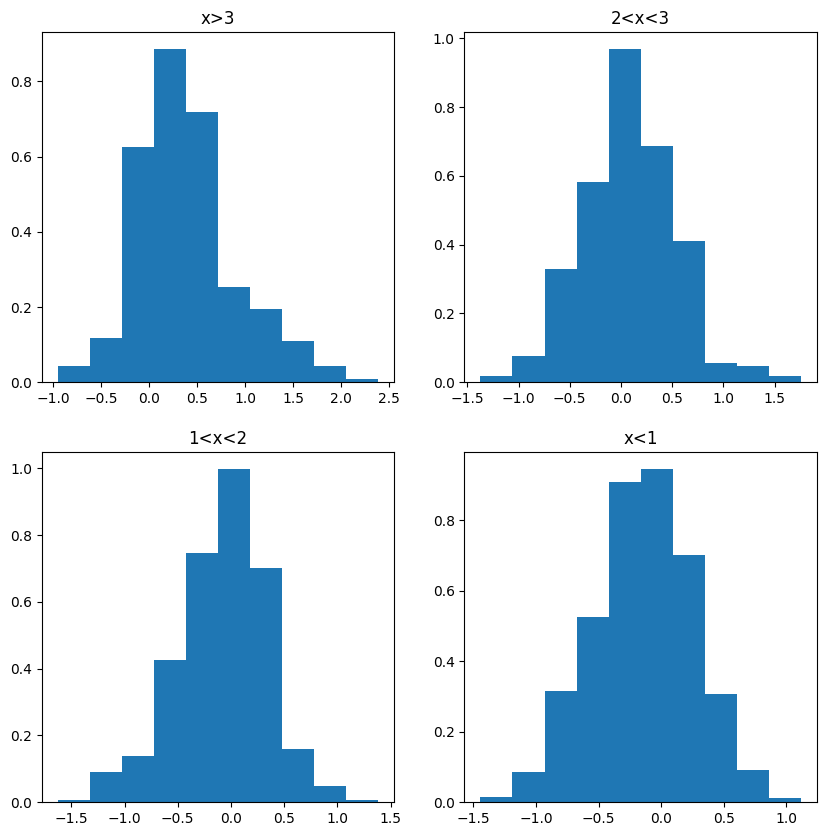

In [12]:
evaluate_wave_error_distr("lasso")

#### ElasticNet

C:\Users\dacoq\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


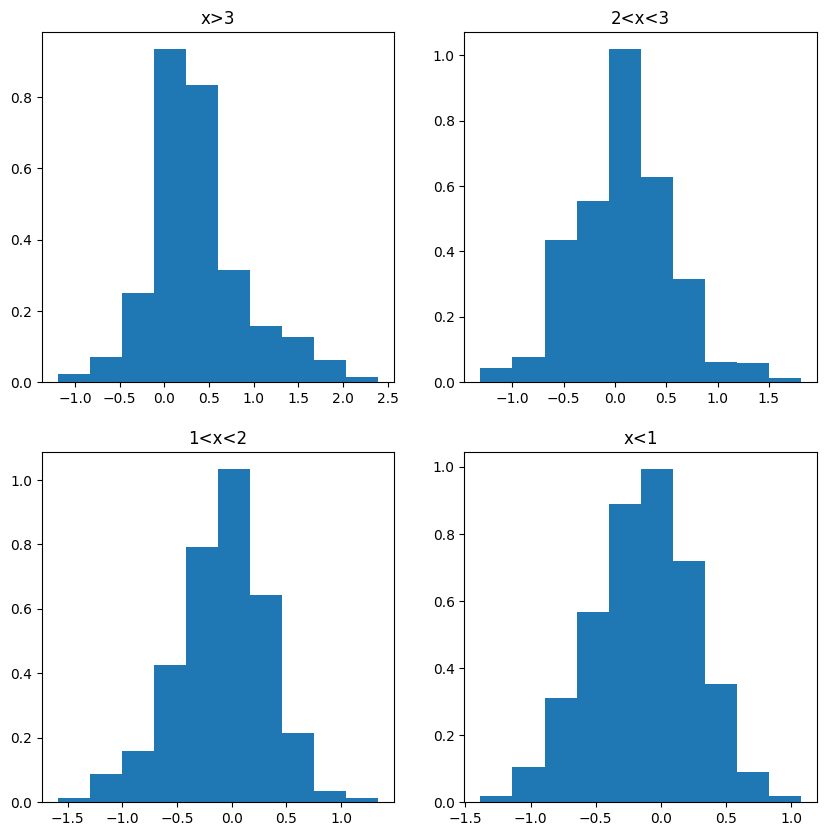

In [13]:
cols = ['moonphase', 'temp', 'rh', 'pressure',
       'vis', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N',
       'wdir_NE', 'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S', 'wdir_SE',
       'wdir_SSE', 'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W', 'wdir_WNW',
       'wdir_WSW', 'Vviento', 'PeriodoOlas', 'Lluvia', 'Nubosidad']
evaluate_wave_error_distr("sel-elastic", X_test[cols])

#### Evaluación para errores en altura de la ola para RandomForest y MLP
(los mejores modelos según las métricas)

In [7]:
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['moonphase', 'temp', 'dewPt', 'heat_index',
                                  'rh', 'pressure', 'vis', 'wc', 'feels_like',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Lluvia', 'Nubosidad'])])

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf_best = RandomForestRegressor(max_depth=28, random_state=RANDOM_SEED, bootstrap=True, min_samples_leaf=1, min_samples_split=4, n_estimators=201)
rf_best.fit(scaler.transform(X_train), y_train)

RandomForestRegressor(max_depth=28, min_samples_split=4, n_estimators=201,
                      random_state=777)

In [9]:
rf_olas_err = pd.DataFrame({"ola": ola_clas, "error": y_test - rf_best.predict(scaler.transform(X_test))})

In [10]:
from sklearn.neural_network import MLPRegressor
mlp_best = MLPRegressor(random_state=RANDOM_SEED, batch_size=652, alpha=0.9101, activation="relu", hidden_layer_sizes=(68,88,89))

mlp_best.fit(scaler.transform(X_train), y_train) 

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.9101, batch_size=652, hidden_layer_sizes=(68, 88, 89),
             random_state=777)

In [14]:
mlp_olas_err = pd.DataFrame({"ola": ola_clas, "error": y_test - mlp_best.predict(X_test)})

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [23]:
xmin = min(mlp_olas_err.min().iloc[1], rf_olas_err.min().iloc[1])
xmax = max(mlp_olas_err.max().iloc[1], rf_olas_err.max().iloc[1])
xmin, xmax

(-2.29925293272017, 4.11686519848363)

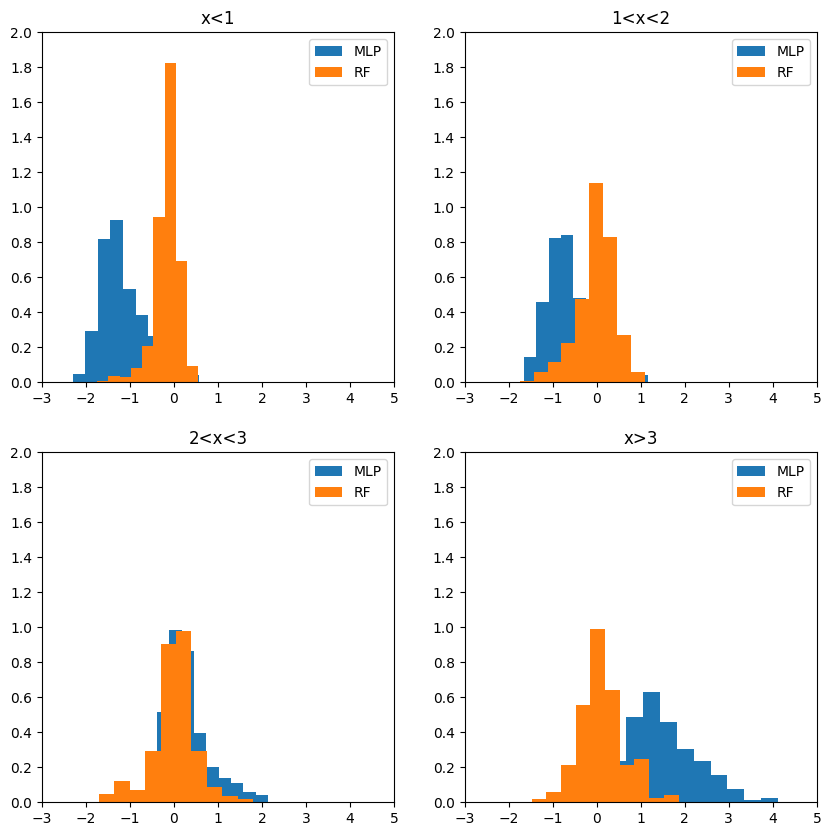

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, o in enumerate(['x<1', '1<x<2', '2<x<3', 'x>3']):
    ax = axs[i//2, i%2]
    ax.hist(mlp_olas_err[mlp_olas_err["ola"] == o].error, label='MLP', density=True)
    ax.hist(rf_olas_err[rf_olas_err["ola"] == o].error, label='RF', density=True)
    ax.set_title(o)
    ax.legend()
    ax.set_xticks(np.linspace(-3, 5, 9))
    ax.set_yticks(np.linspace(0, 2, 11))